# A Multi-Horizon Quantile Recurrent Forecaster

In [16]:
import pandas as pd
import numpy as np
import pathlib as plt

%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (6,6)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\Users\SESA626862\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\magics\pylab.py:166: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [21]:
# PyTorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset

# PyTorch Lightning imports
import pytorch_lightning as pl

# Información del conjunto de datos a utilizar


##### Descripción
El conjunto de datos [1] no tiene valores faltantes.
Los valores están en kW de cada 15 min. Para convertir los valores en kWh, los valores deben dividirse por 4.
Cada columna representa un cliente. Algunos clientes se crearon después de 2011. En estos casos, el consumo se consideró cero.
Todas las etiquetas de tiempo informan en hora portuguesa. Sin embargo, todos los días presentan 96 medidas (24*4). 
Cada año, en el día de cambio de hora de marzo (que tiene solo 23 horas), los valores entre la 1:00 am y las 2:00 am son cero para todos los puntos. 
Cada año, en el día de cambio de hora de octubre (que tiene 25 horas), los valores entre la 1:00 am y las 2:00 am agregan el consumo de dos horas.

##### Información de la variable
El conjunto de datos se guardó como texto en formato csv, utilizando punto y coma (;).
La ​​primera columna presenta la fecha y la hora como una cadena con el siguiente formato 'aaaa-mm-dd hh:mm:ss'
Las demás columnas presentan valores flotantes con el consumo en kW


In [8]:

eldata = pd.read_csv(r"./LD2011_2014.txt",
             parse_dates=[0],
             delimiter=";",
             decimal=",")
eldata.rename({"Unnamed: 0": "timestamp"}, axis=1, inplace=True)
eldata.head()

,timestamp,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
0,2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


El conjunto de datos contiene el consumo de electricidad de 370 clientes en kW, medido cada 15 minutos. Remuestreémoslo a un período de 1 hora:


In [9]:
eldata = eldata.resample("1h", on="timestamp").mean()

Dado que hay clientes cuya medición comenzó después de 2011, esperamos que algunos clientes tengan un alto porcentaje de ceros (como se documenta en la página del conjunto de datos):

Text(0, 0.5, 'non-zero %')

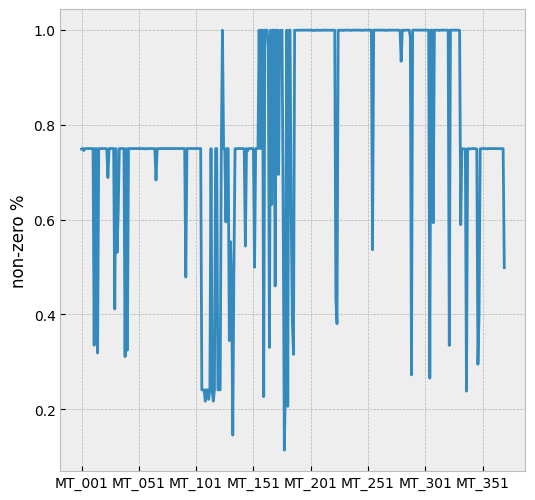

In [17]:
(eldata!=0).mean().plot()
plt.ylabel("non-zero %")

De hecho, podemos ver que algunos clientes tienen un bajo porcentaje de valores distintos de cero.

Para examinar cuánta variación hay entre la magnitud de los valores entre clientes, graficaremos las medianas de todos los clientes (ordenadas):

Text(0, 0.5, 'magnitude')

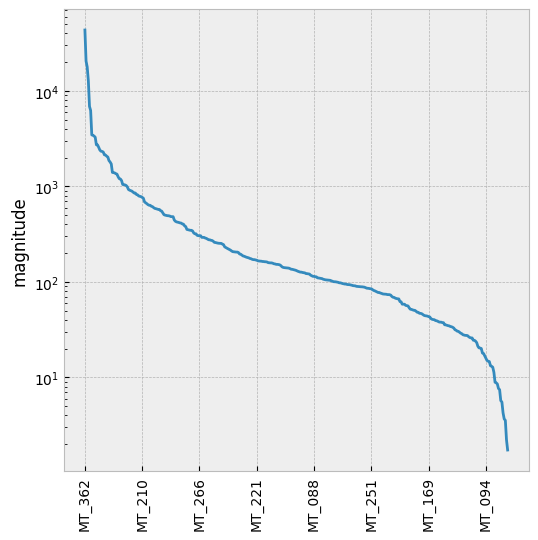

In [18]:
eldata[eldata!=0].median().sort_values(ascending=False).plot(rot=90)
plt.yscale("log")

plt.ylabel("magnitude")

Podemos ver que la mayoría de los clientes se encuentran en la región de valores de 10^3 y 10^4
Sin embargo, hay una diferencia de casi 5 órdenes de magnitud (!) entre la mediana mínima y la máxima, por lo que deberíamos normalizar la entrada antes de alimentar la red.

# Conjunto de datos y módulo de datos

In [22]:
class ElectricityLoadDataset(Dataset):
    """Sample data from electricity load dataset (per household, resampled to one hour)."""

    def __init__(self, df, samples, hist_len=168, fct_len=24):
        self.hist_num = hist_len
        self.fct_num = fct_len
        self.hist_len = pd.Timedelta(hours=hist_len)
        self.fct_len = pd.Timedelta(hours=fct_len)
        self.offset = pd.Timedelta(hours=1)
        self.samples = samples

        self.max_ts = df.index.max() - self.hist_len - self.fct_len + self.offset
        self.raw_data = df.copy()

        assert samples <= self.raw_data[:self.max_ts].shape[0]

        self.sample()

    def sample(self):
        """Sample individual series as needed."""

        # Calculate actual start for each household
        self.clean_start_ts = (self.raw_data!=0).idxmax()

        households = []

        for hh in self.raw_data.columns:
            hh_start = self.clean_start_ts[hh]
            hh_nsamples = min(self.samples, self.raw_data.loc[hh_start:self.max_ts].shape[0])

            hh_samples = (self.raw_data
                          .loc[hh_start:self.max_ts]
                          .index
                          .to_series()
                          .sample(hh_nsamples, replace=False)
                          .index)
            households.extend([(hh, start_ts) for start_ts in hh_samples])

        self.samples = pd.DataFrame(households, columns=("household", "start_ts"))

        # Adding calendar features
        # In fact we should use self.raw_data shifted by 1 since the calendar features are deterministic hence unlike
        # the endogenos part when we use z(t) to predict z(t+1), we can use x(t) to predict z(t) but anywy since the feature is
        # in fact fourier feature it is not critical
        self.raw_data["yearly_cycle"] = np.sin(2 * np.pi * self.raw_data.index.dayofyear / 366)
        self.raw_data["weekly_cycle"] = np.sin(2 * np.pi * self.raw_data.index.dayofweek / 7)
        self.raw_data["daily_cycle"] = np.sin(2 * np.pi * self.raw_data.index.hour / 24)
        self.calendar_features = ["yearly_cycle", "weekly_cycle", "daily_cycle"]

    def __len__(self):
        return self.samples.shape[0]

    def __getitem__(self, idx):
        household, start_ts = self.samples.iloc[idx]

        hs, he = start_ts, start_ts + self.hist_len - self.offset
        fs, fe = he + self.offset, he + self.fct_len

#         hist_data = self.raw_data.loc[hs:, [household] + self.calendar_features].iloc[:self.hist_num]
#         fct_data = self.raw_data.loc[fs:, [household] + self.calendar_features].iloc[:self.fct_num]
        hist_data = self.raw_data.loc[hs:he, [household] + self.calendar_features]
        fct_data = self.raw_data.loc[fs:fe, [household] + self.calendar_features]
        
        # scaling: 
        mean = hist_data.loc[:,household].mean()
        std = hist_data.loc[:,household].std()
        if std == 0:
            std = 1
        hist_data.loc[:,household] = (hist_data.loc[:,household] - mean) / std
        fct_data.loc[:,household] = (fct_data.loc[:,household] - mean) / std

        return (torch.Tensor(hist_data.values),
                torch.Tensor(fct_data.values), (mean,std))

In [24]:
ds = ElectricityLoadDataset(eldata, 100)
hist, fct, (mean, std) = ds[4]
mean, std

(5.100691926516799, 4.049224828955029)

Compruebe la longitud correcta

In [25]:
hist.shape

torch.Size([168, 4])

In [26]:
fct.shape

torch.Size([24, 4])

Compruebe el numero de muestras por cliente

In [27]:
ds.samples

,household,start_ts
0,MT_001,2014-01-11 04:00:00
1,MT_001,2012-10-11 10:00:00
2,MT_001,2013-09-25 18:00:00
3,MT_001,2013-09-05 00:00:00
4,MT_001,2012-02-02 11:00:00
...,...,...
36995,MT_370,2014-11-19 10:00:00
36996,MT_370,2014-03-30 15:00:00
36997,MT_370,2014-08-27 13:00:00
36998,MT_370,2013-11-16 08:00:00


In [28]:
ds.samples.groupby("household").size().unique()

array([100], dtype=int64)

Como lo esperado, tenemos 100 muestras por cliente


# Verificar la exactitud de los datos
Verificamos la exactitud comparando los datos que obtenemos del cargador de conjuntos de datos con los datos brutos correspondientes. Para ello, primero obtenemos el hogar y la marca de tiempo de inicio del atributo samples para el mismo índice que muestreamos anteriormente para obtener hist, fct y (mean, std) y obtener los datos correspondientes directamente del marco de datos:

In [29]:
household, start_ts = ds.samples.iloc[4]
eldata.loc[start_ts:,household].head()

timestamp
2012-02-02 11:00:00    12.690355
2012-02-02 12:00:00    13.642132
2012-02-02 13:00:00     2.538071
2012-02-02 14:00:00    13.642132
2012-02-02 15:00:00    12.690355
Freq: h, Name: MT_001, dtype: float64

In [30]:
eldata.loc[start_ts+pd.Timedelta(days=7):,household].head()

timestamp
2012-02-09 11:00:00    4.758883
2012-02-09 12:00:00    5.076142
2012-02-09 13:00:00    1.586294
2012-02-09 14:00:00    6.027919
2012-02-09 15:00:00    1.903553
Freq: h, Name: MT_001, dtype: float64

Ahora, comparando lo anterior con los datos no normalizados que obtuvimos del cargador de conjuntos de datos:

In [31]:
hist[:,0]*std +mean, fct[:,0]*std + mean

(tensor([12.6904, 13.6421,  2.5381, 13.6421, 12.6904,  9.2005,  9.2005,  2.2208,
          2.8553,  2.8553,  3.1726,  2.8553,  2.5381,  2.5381,  2.5381,  2.5381,
          2.5381,  2.5381,  2.8553,  2.5381,  2.2208,  3.1726, 10.4695,  3.8071,
          3.1726,  3.1726,  3.1726,  2.8553,  3.1726,  1.9036,  1.2690,  3.1726,
          3.8071,  3.8071,  3.8071,  4.1244,  3.8071,  3.8071,  3.8071,  4.1244,
          3.8071,  4.1244,  3.8071,  3.8071,  3.8071,  1.9036,  1.2690, 10.1523,
          2.5381,  1.5863,  6.0279,  6.0279,  2.5381,  1.9036,  2.5381,  3.8071,
          3.4898,  3.8071,  4.1244,  3.4898,  4.1244,  3.8071,  3.4898,  3.8071,
          3.8071,  3.4898,  3.8071,  4.1244,  3.4898,  3.4898,  6.0279,  9.8350,
          1.2690,  5.7107,  5.3934,  1.2690,  2.8553,  4.4416,  1.2690,  2.5381,
          2.8553,  2.8553,  3.1726,  2.8553,  3.4898,  2.8553,  2.8553,  3.1726,
          3.1726,  3.1726,  2.8553,  3.1726,  3.1726,  6.6624,  8.5660, 15.5457,
          4.7589,  5.0761,  

Vemos que los datos son idénticos, como se esperaba.

# Módulo de datos

In [33]:
class ElectricityLoadDataModule(pl.LightningDataModule):
    """DataModule for electricity data."""

    def __init__(self, df,
                 train=0.7, 
                 val=0.2,
                 test=0.1,
                 samples=100,
                 batch_size=64,
                 workers=3):

        super().__init__()

        assert train + val + test <= 1

        self.raw_data = df
        self.train_size = int(train * df.shape[1])
        self.val_size = int(val * df.shape[1])
        self.test_size = df.shape[1] - self.train_size - self.val_size

        self.samples = samples
        self.batch_size = batch_size
        self.workers = workers
        self.split()

    def split(self):
        hh_rand = (self.raw_data
                   .columns
                   .to_series()
                   .sample(self.raw_data.shape[1],
                           replace=False))

        self.train_hh = hh_rand.iloc[:self.train_size].index
        self.val_hh = hh_rand.iloc[self.train_size:(self.val_size + self.train_size)].index
        self.test_hh = hh_rand.iloc[-self.test_size:].index

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            train_df = self.raw_data[self.train_hh]
            val_df = self.raw_data[self.val_hh]

            self.train_ds = ElectricityLoadDataset(train_df,
                                                   samples=self.samples)
            self.val_ds = ElectricityLoadDataset(val_df,
                                                 samples=self.samples)

        if stage == "test" or stage is None:
            test_df = self.raw_data[self.test_hh]
            self.test_ds = ElectricityLoadDataset(test_df,
                                              samples=self.samples)

    
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, num_workers=self.workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, num_workers=self.workers, shuffle=True)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=self.workers, shuffle=True)
    

In [34]:
# dm = ElectricityLoadDataModule(eldata)
dm = ElectricityLoadDataModule(eldata, workers=0)
dm.setup()

Verifique que el conjunto de entrenamiento no se superponga con los conjuntos val o test y que todos sumen 370:

In [35]:
assert dm.train_hh.intersection(dm.val_hh).empty
assert dm.train_hh.intersection(dm.test_hh).empty
assert dm.train_hh.size + dm.val_hh.size + dm.test_hh.size == 370

Realizar algunas pruebas en un lote de entrenamiento muestreado:

In [36]:
x, y, (mean, std) = next(iter(dm.train_dataloader()))
x.shape, y.shape

(torch.Size([64, 168, 4]), torch.Size([64, 24, 4]))

In [37]:
mean

tensor([6.6167e+01, 7.3311e+01, 1.0437e+02, 2.8780e+02, 1.2562e+02, 2.8486e+02,
        4.1700e+02, 1.4259e+03, 3.7066e+01, 9.6909e+01, 1.0133e+02, 4.7271e+01,
        2.0660e+00, 4.2364e+01, 9.3771e+01, 3.4675e+00, 7.4529e+02, 6.6662e+01,
        2.6309e+02, 3.6201e+02, 1.2943e+01, 1.5473e+02, 1.3929e+02, 2.3987e+03,
        1.8465e+02, 4.3003e+01, 3.6496e+02, 2.7192e+02, 1.3735e+03, 1.2937e+02,
        2.7296e+03, 1.4845e+03, 1.7825e+02, 4.0583e+01, 6.6654e+02, 6.4425e+01,
        2.0576e+02, 1.1064e+01, 4.2555e+01, 6.0255e+02, 6.9294e+02, 1.2560e+03,
        1.7349e+01, 1.5984e+02, 1.3820e+02, 5.3555e+01, 2.0241e+01, 2.2150e+02,
        1.5896e+02, 1.8654e+03, 1.4776e+02, 1.1573e+02, 5.7909e+02, 1.7654e+01,
        2.8228e+02, 1.1052e+02, 7.6169e+02, 1.8675e+02, 1.9310e+02, 3.9661e+01,
        1.5769e+02, 3.8403e+02, 4.4453e+02, 7.1004e+01], dtype=torch.float64)

In [39]:
std

tensor([1.8638e+01, 3.0463e+01, 2.5649e+01, 7.6320e+01, 4.6452e+01, 7.6767e+01,
        1.7045e+02, 3.9916e+02, 7.4069e+00, 6.2259e+01, 3.5710e+01, 2.5247e+01,
        2.3828e+00, 1.6102e+01, 2.2113e+01, 1.1333e+00, 2.2645e+02, 1.6162e+01,
        1.6591e+02, 1.6680e+02, 5.3613e+00, 1.0799e+02, 3.5079e+01, 5.2368e+02,
        5.7526e+01, 7.4320e+01, 1.2230e+02, 4.9224e+01, 3.9099e+02, 2.9622e+01,
        1.0379e+03, 5.2181e+02, 4.4999e+01, 2.8551e+01, 2.5099e+02, 4.4671e+01,
        6.6969e+01, 8.3550e+00, 2.3704e+01, 1.5245e+02, 2.2355e+02, 3.7517e+02,
        6.9776e-02, 6.2070e+01, 5.5789e+01, 5.6439e+01, 1.5259e+01, 5.3742e+01,
        1.1340e+02, 1.0210e+03, 5.5213e+01, 3.7153e+01, 1.4005e+02, 1.4107e+01,
        6.3592e+01, 2.3288e+01, 2.5505e+02, 7.2870e+01, 3.7497e+01, 1.3882e+01,
        8.2668e+01, 8.4636e+01, 1.1667e+02, 4.3461e+01], dtype=torch.float64)

In [40]:
dm.test_ds.samples

,household,start_ts
0,MT_063,2012-06-14 23:00:00
1,MT_063,2014-07-27 23:00:00
2,MT_063,2012-11-22 22:00:00
3,MT_063,2013-01-20 19:00:00
4,MT_063,2013-08-14 13:00:00
...,...,...
3695,MT_282,2014-01-02 13:00:00
3696,MT_282,2013-03-28 15:00:00
3697,MT_282,2013-05-15 15:00:00
3698,MT_282,2012-10-20 00:00:00


De hecho, dado que la prueba es del 10% de los datos = 37 hogares, y muestreamos cada hogar 100 veces, obtenemos el número total esperado de muestras: 3700.

# Modelo

In [41]:
class ElectricityModel(pl.LightningModule):
    """Encoder network for MQ-RNN forecast model."""
    def __init__(self, hist_len=168, fct_len=24, input_size=4, num_layers=1, hidden_units=8, ct_size=8, ca_size=8,
                 quantiles=[0.1,0.5,0.9], min_hist_len = 120, lr=1e-3):
        super().__init__()
        self.hist_len = hist_len
        self.fct_len = fct_len
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_units = hidden_units
        self.ct_size = ct_size
        self.ca_size = ca_size
        self.quantiles = quantiles
        self.n_quantiles = len(quantiles)
        self.min_hist_len = min_hist_len
        self.lr = lr
        self.global_in_features = hidden_units + fct_len * (input_size - 1)
        self.global_out_features = ca_size + fct_len * ct_size
        self.local_in_features = ca_size + ct_size + input_size - 1

        self.encoder = nn.LSTM(input_size=self.input_size,
                               hidden_size=self.hidden_units,
                               num_layers=self.num_layers,
                               batch_first=True)
        self.global_mlp = nn.Linear(in_features= self.global_in_features, out_features=self.global_out_features)
        self.local_mlp = nn.Linear(in_features=self.local_in_features, out_features=self.n_quantiles)

    def forward(self, x, x_f, hidden=None):
        # x is of size (batch_size, x_seq_len, input_size), where x_seq_len can be any arbitrary sequence length
        # and x_f is of size (batch_size, fct_len, input_size - 1) since it contains only the exogenous covariates
        
        # get the hidden state from the encoder
        _, (hn, cn) = self.encoder(x, hidden)
        
        # concatenate the hidden state with the future covariates. h_n is of size (1, batch_size, hidden_units) so I will
        # squeeze it and reshape x_f to get the desired number of in_features.
        hn_s = hn.squeeze() # to get (batch_size,hidden_units) size
        x_f_vec = x_f.reshape(-1, x_f.shape[1] * x_f.shape[2]) # to get (batch_size, fct_len * (input_size - 1)) size
        global_input = torch.cat([x_f_vec,hn_s], dim=1)
        contexts = self.global_mlp(global_input) # (batch_size, ca_size + fct_len * ct_size)
        
        # create ct :tensor with batch_size in 1st dim., fct_len in the 2nd and ct_size in the 3rd.
        ct = contexts[:,self.ca_size:].reshape(-1, self.fct_len, self.ct_size)
        # ca is constant to all horizon so we need to replicate it in the 2nd dim (after reshpe from 2 to 3 dims.)
        ca = contexts[:,:self.ca_size].view(-1, 1, self.ca_size).expand(-1,self.fct_len,-1)
        local_input = torch.cat([ca,ct,x_f],dim=2) # to get (batch_size, fct_len, ca_size + ct_size + input_size - 1) size
        y_hat = self.local_mlp(local_input) # (barch_size, fct_len, n_quantiles)
        
        return y_hat, hn, cn
    
    def training_step(self, batch, batch_idx):
        
        x, y, _ = batch
        x_cat = torch.cat([x, y], dim=1)
        
        # first forward on min_hist_len to get the hidden states and compute the corresponding loss
        y_hat, hn, cn = self(x_cat[:, :self.min_hist_len, :], x_cat[:, self.min_hist_len:self.min_hist_len+self.fct_len, 1:])
        loss = self.loss(y_hat, x_cat[:, self.min_hist_len:self.min_hist_len+self.fct_len, [0]])
        
        # forking-sequences implementation: we move on the hist. series one by one and forecast for the next <fct_len>, 
        # then add the current loss to the aggregated one
        for i in range(self.min_hist_len,self.hist_len):
            y_hat, hn, cn = self(x_cat[:, i:i+1, :], x_cat[:, i+1:i+1+self.fct_len, 1:], (hn, cn))
            loss += self.loss(y_hat, x_cat[:, i+1:i+1+self.fct_len, [0]])
        
        return loss / (self.hist_len - self.min_hist_len + 1)
            
    def validation_step(self, batch, batch_idx):
        # we need to validate only on full length series (and not perform forking-sequences as in the training)
        x, y, _ = batch
        
        y_hat, hn, cn = self(x, y[:, :, 1:])
        loss = self.loss(y_hat, y[:, :, [0]])

        self.log('val_QL', loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def loss(self, y_hat, y):
        # y, y_hat and self.quantiles need to be broadcastable: https://pytorch.org/docs/stable/notes/broadcasting.html
        # usually y: (batch_size, fct_len, 1), y_hat: (batch_size,fct_len,self.n_quantiles), quantiles: (self.n_quantiles)
        zeros = torch.zeros_like(y_hat)
        quantiles = torch.tensor(self.quantiles,device=y.device)
        error = y - y_hat
        return torch.mean(quantiles * torch.maximum(error, zeros) + (1 - quantiles) * torch.maximum(-error, zeros))   

# Prueba del modelo Electricity

In [42]:
dm = ElectricityLoadDataModule(eldata, batch_size=128, workers=0)
model = ElectricityModel(lr=1e-3, hidden_units=64, ca_size = 64, ct_size = 16, num_layers=1)
dm.setup()
batch = next(iter(dm.train_dataloader()))
# batch = next(iter(dm.test_dataloader()))
X, y, (mean, std) = batch
y_hat, _, _ = model.forward(X, y[:,:,1:])
y_hat.shape

torch.Size([128, 24, 3])

Como se esperaba, la longitud de la secuencia de salida es 24 y su tamaño es 3, como el número de cuantiles (esos 2 parámetros, por supuesto, se pueden cambiar en la inicialización del modelo).

Pruebe que el paso de entrenamiento se ejecuta sin errores:

In [43]:
model.training_step(batch, 0)

tensor(0.4364, grad_fn=<DivBackward0>)

# Entrenamiento

In [47]:
# dm = ElectricityLoadDataModule(scaled_data, batch_size=128, workers=0)
dm = ElectricityLoadDataModule(eldata, batch_size=128, workers=0)
model = ElectricityModel(lr=1e-3, hidden_units=64, ca_size = 64, ct_size = 16, quantiles = [0.01,0.1,0.5,0.9,0.99],
                         num_layers=1)
trainer = pl.Trainer(max_epochs=20)
# trainer = pl.Trainer(max_epochs=5, progress_bar_refresh_rate=1, accelerator='ddp_cpu')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [48]:
trainer.fit(model, dm)


  | Name       | Type   | Params | Mode 
----------------------------------------------
0 | encoder    | LSTM   | 17.9 K | train
1 | global_mlp | Linear | 61.4 K | train
2 | local_mlp  | Linear | 420    | train
----------------------------------------------
79.7 K    Trainable params
0         Non-trainable params
79.7 K    Total params
0.319     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\SESA626862\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\SESA626862\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


c:\Users\SESA626862\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 203/203 [02:32<00:00,  1.33it/s, v_num=0, val_QL=0.0752]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 203/203 [02:32<00:00,  1.33it/s, v_num=0, val_QL=0.0752]


In [49]:
dm.setup(stage="test")
batch = next(iter(dm.test_dataloader()))
X, y, (mean, std) = batch
X.shape

torch.Size([128, 168, 4])

In [50]:
result = model(X, y[:,:,1:])
result[0].shape

torch.Size([128, 24, 5])

In [51]:
std.shape

torch.Size([128])

In [52]:
res = result[0]*std.view(-1,1,1) + mean.view(-1,1,1)
x = X[:,:,0]*std.view(-1,1) + mean.view(-1,1)
y = y[:,:,0]*std.view(-1,1) + mean.view(-1,1)

res = res.cpu().detach().numpy()
x = x.cpu().detach().numpy()
y = y.cpu().detach().numpy()

quantiles_num = len(model.quantiles)
half = (quantiles_num - 1) // 2
res.shape

(128, 24, 5)

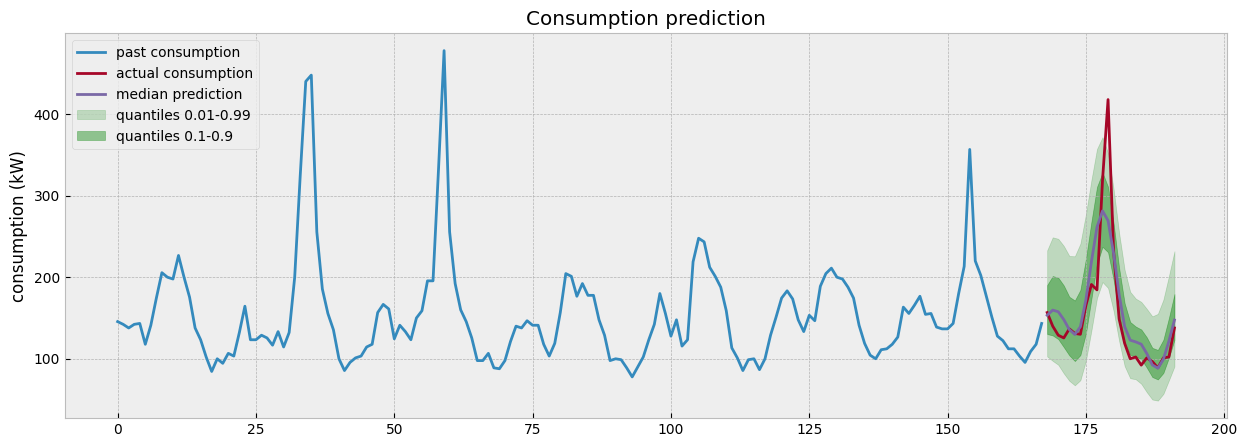

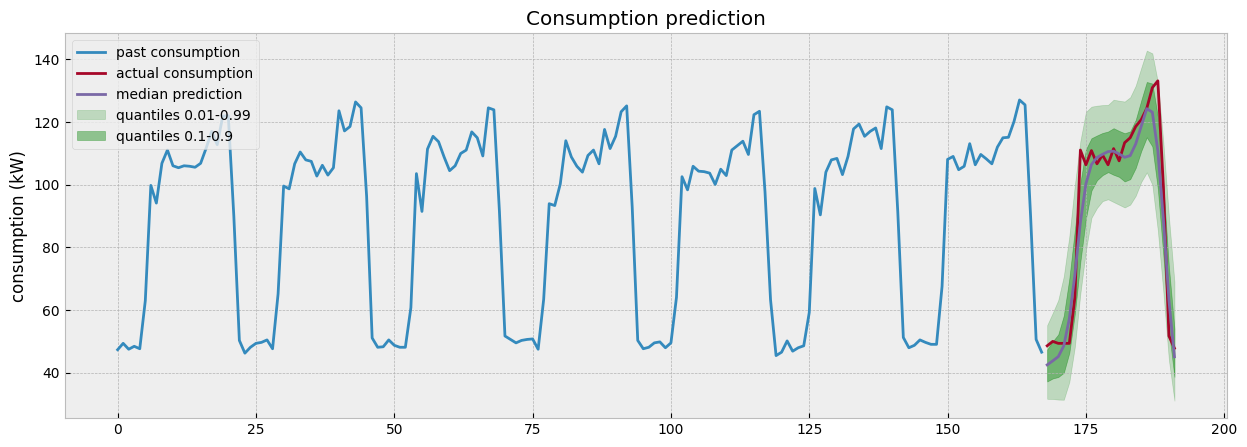

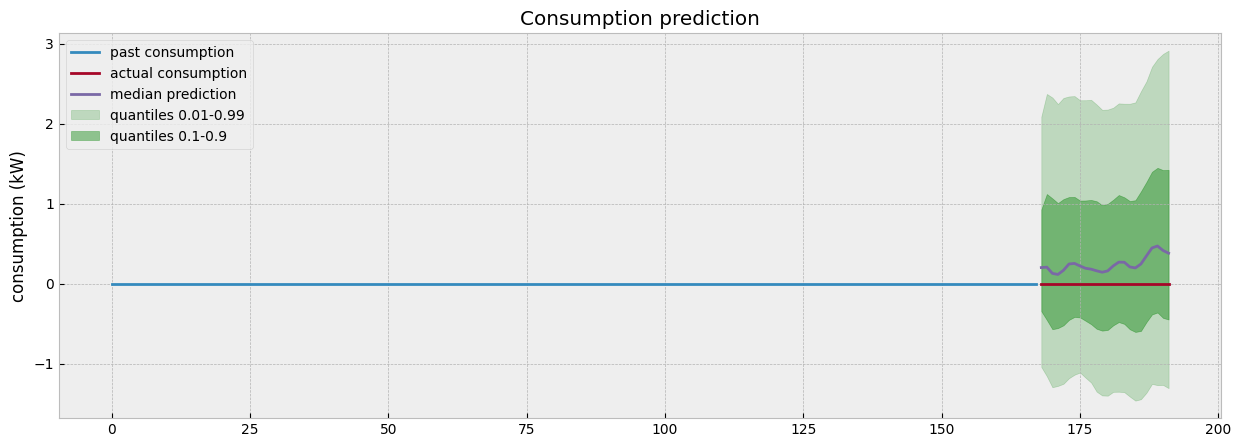

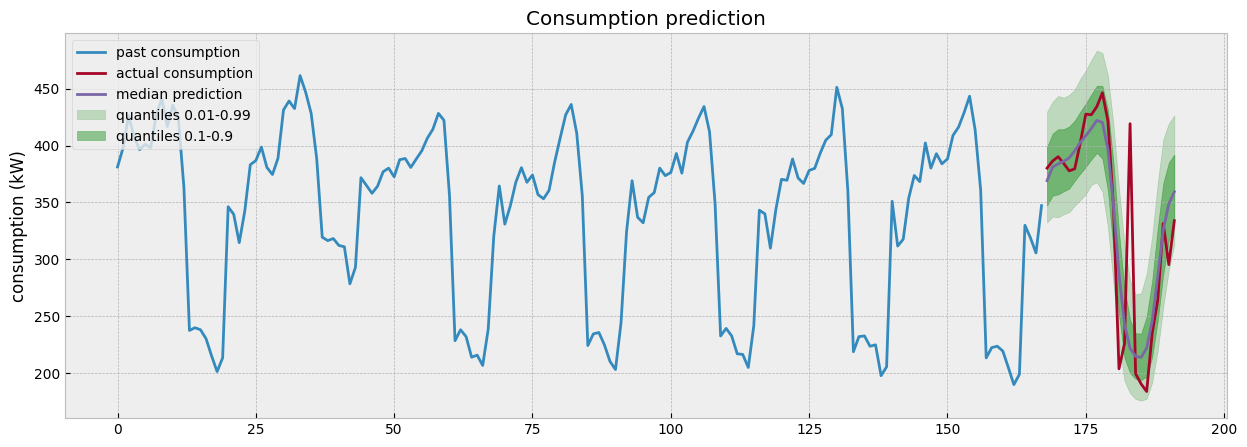

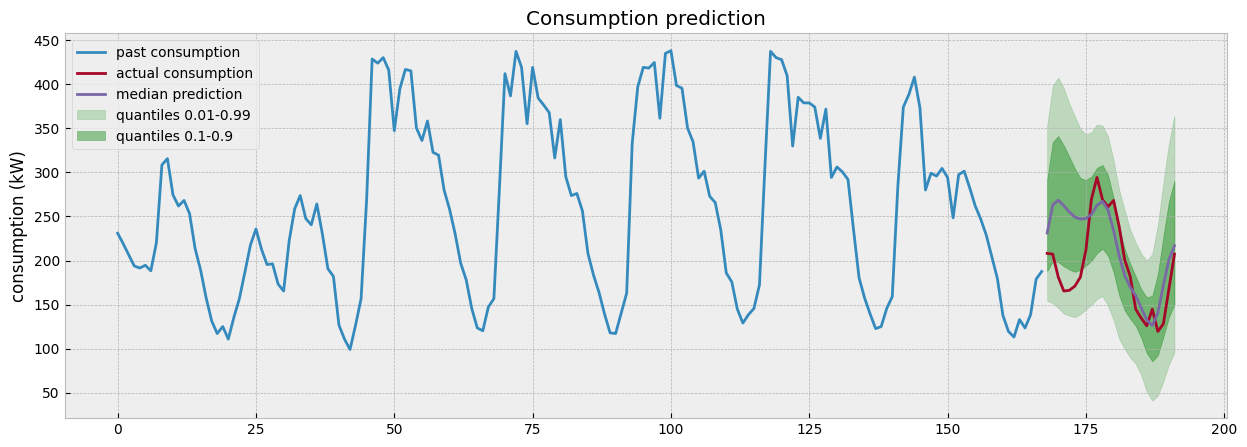

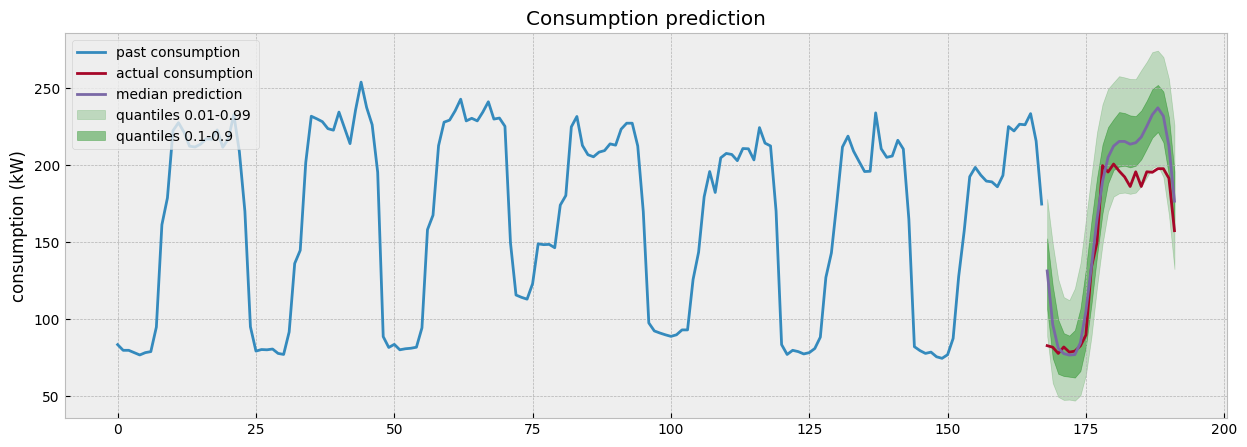

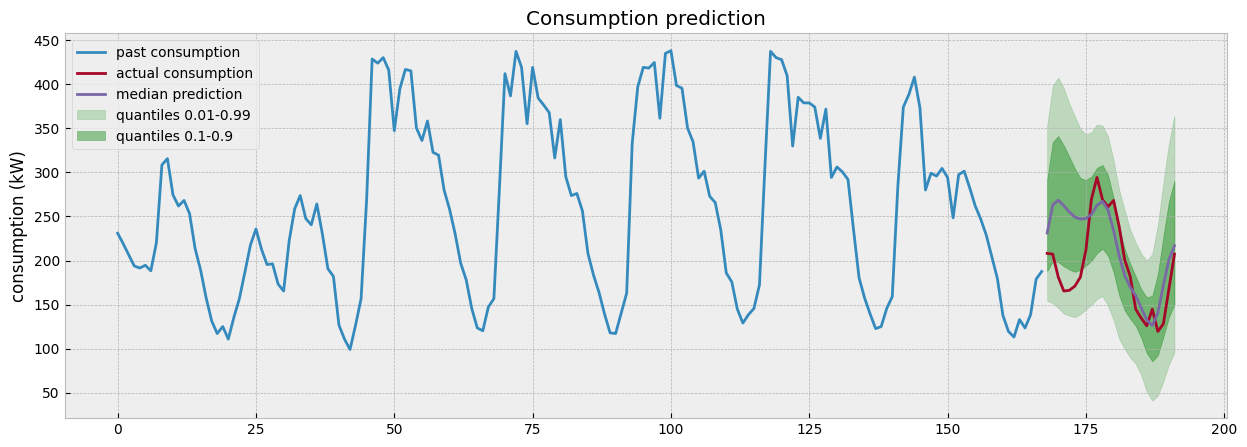

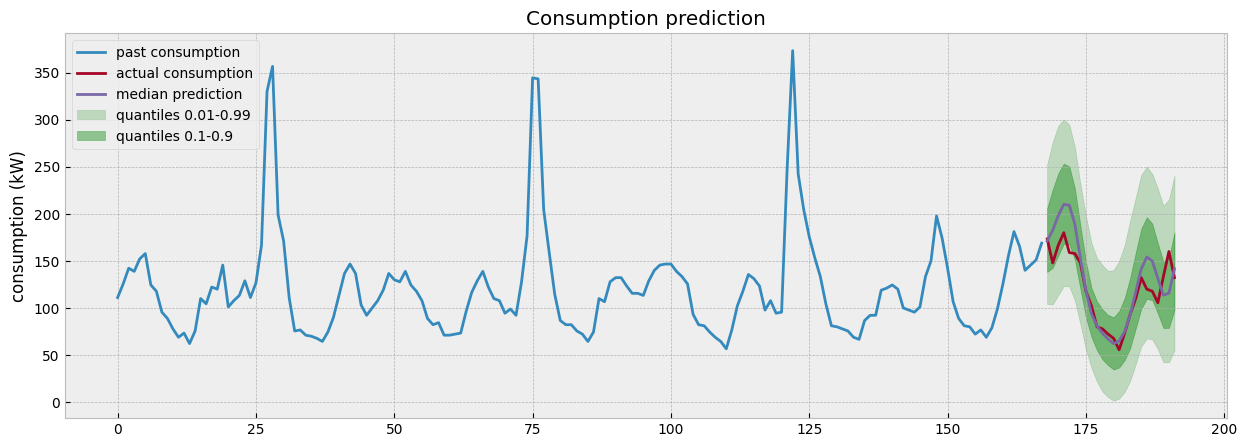

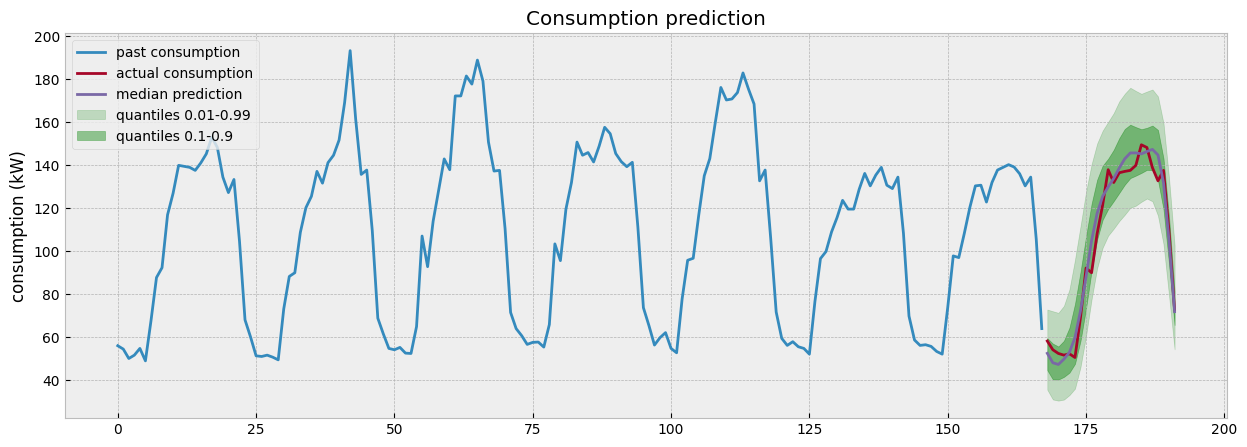

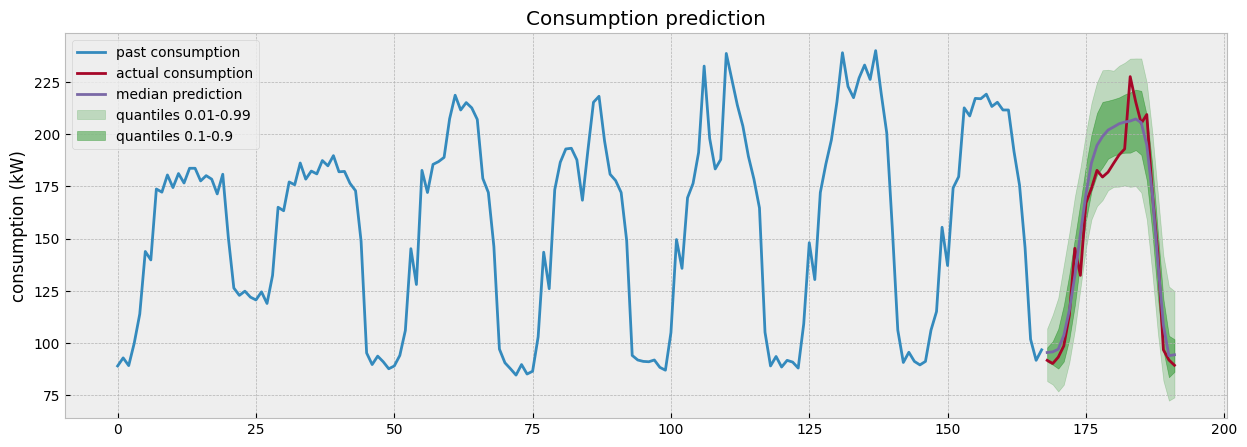

In [53]:
samples = np.random.randint(res.shape[0],size=10)

for n in samples:
    fig = plt.figure(figsize=(15,5))
    plt.title("Consumption prediction")
    plt.plot(x[n,:], label="past consumption")
    plt.plot(np.arange(168, 192, 1), y[n, :], label="actual consumption")
    plt.plot(np.arange(168, 192, 1), res[n, :, half], label="median prediction")
    # res = res[:, 1:]
    for i in range(half):
        alph = 0.0 + (i + 1)/ quantiles_num
        plt.fill_between(np.arange(168, 192, 1), res[n, :, i], res[n, :, -(i + 1)],
                         color="g", alpha=alph, label=f"quantiles {model.quantiles[i]}-{model.quantiles[-(i + 1)]}")

    plt.legend(loc="upper left")
    # plt.grid()
    # plt.tight_layout()
    plt.ylabel("consumption (kW)")
    plt.show()

# Referencias 

1. https://archive.ics.uci.edu/dataset/321/electricityloaddiagrams20112014
2. https://arxiv.org/pdf/1711.11053